## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [1]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
%matplotlib inline

In [2]:
df = pd.read_csv("train_kaggle.csv", index_col = 'Id')
test = pd.read_csv('test_kaggle.csv',index_col='Id')
df.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


### Model 1
- get dummies for all categorical variables
- fill na values with the mean
- use the standard scaler
- split the data into train and test
- perform simple linear regression using some reasonable value for the tolerance and learning rate
- evaluate based on root mean squared logarithmic error (what the kaggle competition uses)

In [3]:
df = pd.get_dummies(df)
df = df.fillna(df.mean())
target = df['SalePrice']
del df['SalePrice']
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.transform(df)


test = pd.get_dummies(test)
test = test.fillna(test.mean())



In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.33, random_state=42)

##### This function calculates root mean squared logarithmic error. This is what the Kaggle Comp. Judges 
- This function comes from Kaggle

In [5]:
def rmsle(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

##### Here we are jusing RandomizedSearchCV to find the best learning rate

In [6]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.001}
Best Negative MSE: -4091996652.096708


- Here we see the results of our first model
- the RMSLE for the train set seems good
- the Test RMSLE is much worse. This suggests overfitting
- We are also getting an error, lets investigate this further

In [7]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 0.10376387334683593
Test RMSLE: 0.2249398983569005


C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


Notice the minimum train and test predictions below
- the train prediction is reasonable
- the test prediction is ridiculous
- we are clearly overfitting and this is causing negative logs which are creating errors

In [8]:
print("minimum train prediction: {}".format(train_predictions.min()))
print("minimum test prediction: {}".format(test_predictions.min()))

minimum train prediction: 40090.01408219928
minimum test prediction: -171012.20649012117


In [9]:

def plot_learning_curve(estimator, title, X, y, ylim=None, 
                        cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

There definitely appears to be a problem with overfitting
- Notice the learning curve
- Training is down near zero
- testing is way above training but approaches in the limit
- classic high variance overfitting result
- we are also getting warnings because there are convergence problems. 

C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\U

<module 'matplotlib.pyplot' from 'C:\\Users\\jonathanjensen\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

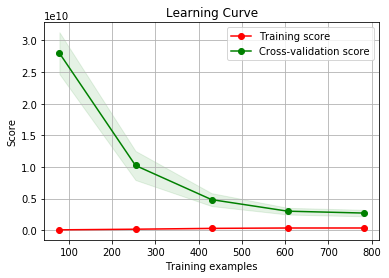

In [10]:
plot_learning_curve(linear_regression_model, "Learning Curve", X_train, y_train, cv=5)

#### Problems with Model 1
- We have tons of independent variables
- We are filling empty values with the mean 
- we are using a simple linear model

## Model 2: Polynomial features
- There really isn't a huge reason to believe that this will help us with our overfitting problem,
- but it's pretty easy to give it a shot

In [11]:
from sklearn.preprocessing import PolynomialFeatures

In [12]:
poly = PolynomialFeatures(2, include_bias=False)
poly_df = poly.fit_transform(df)
scaled_poly_df = scaler.fit_transform(poly_df)
X_train, X_test, y_train, y_test = train_test_split(scaled_poly_df, target, test_size=0.33, random_state=42)

In [13]:
linear_regression_model.fit(scaled_poly_df, target)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 15.217466308938626
Test RMSLE: 15.324825461928588


C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


The Polynomial features model looks pretty bad. Let's try some feature selection to deal with the overfitting. 


### 3. Regularization using Lasso/Ridge

In [14]:
#back to our linear regression model
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.33, random_state=42)

In [15]:
from sklearn.linear_model import ElasticNetCV

# l1 ratio of zero is l2 and visa-versa 
# alphas are how much to weight regularization
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=100000)
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))


Train MSE: 571075997.4748292
Test MSE: 1067905640.6548494


- I will now take the coefficients and try dropping columns with coefficient values less than .1

In [16]:
reg = df.copy()
beta = clf.coef_
b = pd.DataFrame(beta)
b[0].describe()

count     288.000000
mean      268.742618
std      1333.877584
min     -6047.664544
25%      -351.516182
50%        -0.000000
75%       583.767182
max      6215.208774
Name: 0, dtype: float64

In [17]:
b = b.transpose()
b.columns= df.columns
for r in reg.columns :
    score = b.loc[0,r]
    if score < 0:
        del reg[r]

In [18]:
df.shape

(1460, 288)

In [19]:
reg.shape

(1460, 153)

- It looks like we got rid of about 130 variables

In [20]:
reg.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Fence_GdPrv,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,0,0,0,0,0,0,0
2,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,0,0,0,0,0,0,0
3,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,0,0,0,0,0,0,0


In [21]:
scaler = StandardScaler()
scaler.fit(reg)
scaled_reg = scaler.transform(reg)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(scaled_reg, target, test_size=0.33, random_state=42)

- Lets search for the best learning rate

In [23]:
param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.001}
Best Negative MSE: -2557969649.377927


In [24]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 0.13466846247618486
Test RMSLE: 0.23981614281726465


C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


- Our model is starting to seem a little more reasonable, but we still seem to have an overfitting problem. 

### Model 4: Polynomial Features on our new regularized data

In [25]:
poly = PolynomialFeatures(2, include_bias=False)
poly_df = poly.fit_transform(reg)
scaled_poly_df = scaler.fit_transform(poly_df)
X_train, X_test, y_train, y_test = train_test_split(scaled_poly_df, target, test_size=0.33, random_state=42)

In [26]:
linear_regression_model.fit(scaled_poly_df, target)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 7.645378822366485
Test RMSLE: 7.659171078942484


C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [27]:
scaled_poly_df[1].shape

(11934,)

- Polynomial Features is still looking pretty bad. With Polynomial features there are just way too many variables, 11934 in fact.


### Model 5: Further Cleaning and Filtering the Data
- Perhaps the month and year have an impact on housing prices
- we can transform month and year into categorical variables 
- we can then repeat the process in models 3-4 and see if we reach improvements. 

- We can now create dummies for month and year and add them to df
- we drop january and 2006 to avoid perfect multicollinearity in regression
- coefficients on months and years become relative to jan 2006

In [28]:
month = pd.get_dummies(df['MoSold'])
year = pd.get_dummies(df['YrSold'])
month.columns = ['jan','feb','mar','apr','may','june','july','aug','sep','oct','nov','dec']
year.columns = ['y2006','y2007','y2008','y2009','y2010']
del month['jan']
del year['y2006']
df = pd.concat([df,month,year], axis = 1)
del df['MoSold']
del df['YrSold']

test = pd.concat([test,month,year],axis=1)
del test['MoSold']
del test['YrSold']

In [29]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.transform(df)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.33, random_state=42)

In [31]:
param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.001}
Best Negative MSE: -4163191200.4677076


In [32]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 0.10747988425348926
Test RMSLE: 0.24242865014026097


C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


- Now lets use the same Regularization process as before

##### Regularization

In [33]:
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=100000)
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 568256711.0748786
Test MSE: 1065865522.4826893


In [34]:
reg = df.copy()

In [35]:
beta = clf.coef_
b = pd.DataFrame(beta)
b = b.transpose()
b.columns= df.columns
for r in reg.columns :
    score = b.loc[0,r]
    if score < 0:
        del reg[r]
        if r in test.columns:
            del test[r]

In [36]:
scaler = StandardScaler()
scaler.fit(reg)
scaled_reg = scaler.transform(reg)
X_train, X_test, y_train, y_test = train_test_split(scaled_reg, target, test_size=0.33, random_state=42)

In [37]:
scaler = StandardScaler()
scaler.fit(reg)
scaled_reg = scaler.transform(reg)
X_train, X_test, y_train, y_test = train_test_split(scaled_reg, target, test_size=0.33, random_state=42)

linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 0.13755366173737346
Test RMSLE: 0.21453127731955987


C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


We still appear to have significant overfitting. We need to further select features

In [38]:
poly = PolynomialFeatures(2, include_bias=True)
poly_df = poly.fit_transform(reg)
scaled_poly_df = scaler.fit_transform(poly_df)
X_train, X_test, y_train, y_test = train_test_split(scaled_poly_df, target, test_size=0.33, random_state=42)

linear_regression_model.fit(scaled_poly_df, target)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 7.063474647981012
Test RMSLE: 7.019173525323365


C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


#### Instead of looking at year built and year remodel lets just look at the time since either building or remodelling

In [39]:
reg['age'] = 2010 - reg[['YearBuilt','YearRemodAdd']].apply(np.max,axis=1)
test['age'] = 2010 - test[['YearBuilt','YearRemodAdd']].apply(np.max,axis=1)


In [40]:
del reg['YearBuilt']
del reg['YearRemodAdd']

del test['YearBuilt']
del test['YearRemodAdd']

#### Now lets try transforming sales price and looking at log sales price
- Notice the distribution of saleprice is fairly skewed, while log sale price looks pretty symmetric. 

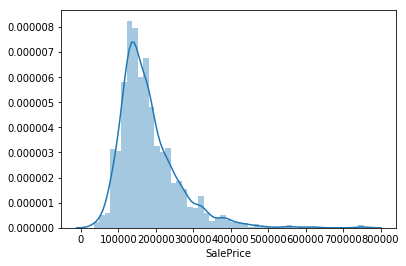

In [41]:
sns.distplot(target)

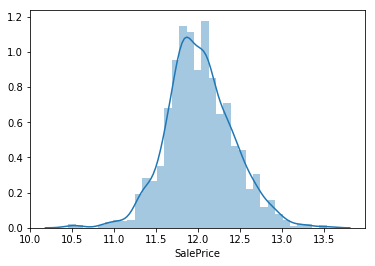

In [42]:
ltarget = np.log(target)
sns.distplot(ltarget)

#### Lets look at correlation with log sale price as a selection mechanism
- We will drop all variables with absolute value correlation under .25 with log sale price

In [43]:
x = pd.concat([reg,ltarget],axis=1)

Copy train and test data that we will further select features from

In [44]:
regc = reg.copy()
testc = test.copy()

In [45]:
corr = x.corr()['SalePrice'].to_frame()
corr['abs_corr'] = abs(corr["SalePrice"])
for r in corr.index:
    selection = corr.loc[r,'abs_corr']
    if selection < .25: 
        del regc[r]
        if r in testc.columns:
            del testc[r]

In [46]:
df.shape

(1460, 301)

In [47]:
reg.shape

(1460, 156)

In [48]:
regc.shape

(1460, 44)

We see that we are now down to 44 independent variables instead of 301

In [49]:
scaler = StandardScaler()
scaler.fit(regc)
scaled_reg = scaler.transform(regc)
X_train, X_test, y_train, y_test = train_test_split(scaled_reg, ltarget, test_size=0.33, random_state=42)

linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

y_train = np.exp(y_train)
y_test = np.exp(y_test)
train_predictions = np.exp(train_predictions)
test_predictions = np.exp(test_predictions)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 0.1563868814263792
Test RMSLE: 0.15928614668470042


In [58]:
testc = testc.fillna(value=testc.mean())
scaler.fit(testc)
scaled_reg = scaler.transform(testc)
res = linear_regression_model.predict(scaled_reg)

In [59]:
results = pd.DataFrame(res)
results[0] = np.exp(results[0])
results.to_csv('final.csv')

### Kaggle Score .212

#### We now seem to have a little higher bias, but at least the train/test RMSLE are closer. Perhaps we have less overfitting. 
- The learning curve also looks a little better

C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1014: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\U

<module 'matplotlib.pyplot' from 'C:\\Users\\jonathanjensen\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

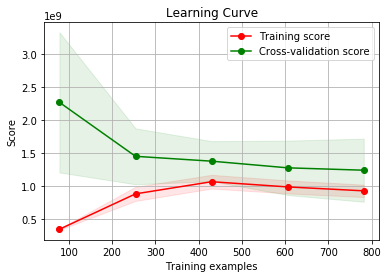

In [60]:
plot_learning_curve(linear_regression_model, "Learning Curve", X_train, y_train, cv=5)

Now lets try adding in some Polynomial Features

In [61]:
poly = PolynomialFeatures(2, include_bias=True)
poly_df = poly.fit_transform(regc)
scaled_poly_df = scaler.fit_transform(poly_df)
X_train, X_test, y_train, y_test = train_test_split(scaled_poly_df, ltarget, test_size=0.33, random_state=42)

linear_regression_model.fit(scaled_poly_df, ltarget)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

y_train = np.exp(y_train)
y_test = np.exp(y_test)
train_predictions = np.exp(train_predictions)
test_predictions = np.exp(test_predictions)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 0.12215733633742945
Test RMSLE: 0.1270585353238066


In [62]:
scaled_poly_df.shape

(1460, 1035)

In [68]:
testc= testc.fillna(value=testc.mean())
test_poly_df = poly.fit_transform(testc)
test_scaled_poly_df = scaler.fit_transform(test_poly_df)
test_predictions = linear_regression_model.predict(test_scaled_poly_df)


In [69]:
res = pd.DataFrame(test_predictions)
res = res.reset_index()
res.columns = ['Id','SalePrice']
res['SalePrice'] = np.exp(res['SalePrice'])
res['Id'] = testc.reset_index()['Id']
res.to_csv('final.csv',index=False)

### I tested out the model above on Kaggle, scored .16

- Things are starting to look a little better. 
- The good RMSLE on Kaggle are about .11

In [70]:
scaled_poly_df.shape

(1460, 1035)

Our model is pretty inconsistent, probably because of the 1770 variables and 1460 observations. 

In [71]:
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=1000)
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

C:\Users\jonathanjensen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Train MSE: 1234325191.651079
Test MSE: 1379506813.1780705


In [72]:
poly = pd.DataFrame(scaled_poly_df)
test_poly = pd.DataFrame(test_scaled_poly_df)

poly.columns = ["c" + str(i) for i in poly.columns]
test_poly.columns = ["c" + str(i) for i in test_poly.columns]

In [73]:
poly.shape

(1460, 1035)

In [74]:
beta = clf.coef_
b = pd.DataFrame(beta)
#b[0] = np.abs(b[0])
b.describe(percentiles= [.1, .25,.3, .6, .9])

,0
count,1035.000000
mean,104.743782
std,84.690466
min,-209.535606
10%,0.000000
25%,61.188747
30%,73.749936
50%,106.590679
60%,122.963334
90%,206.002198


Lets Eliminate any parameters that are below the 50th percentile

In [77]:
polycv = poly.copy()
testcv = test_poly.copy()
b = b.transpose()
b.columns = polycv.columns
for r in polycv.columns:
    score = b.loc[0,r]
    if score < 0:
        del polycv[r]
        del testcv[r]

In [78]:
polycv.shape

(1460, 937)

In [79]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.001, max_iter = 100000)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(polycv, ltarget, test_size=0.33, random_state=42)
linear_regression_model.fit(polycv, ltarget)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)
y_train = np.exp(y_train)
y_test = np.exp(y_test)
train_predictions = np.exp(train_predictions)
test_predictions = np.exp(test_predictions)

train_mse = rmsle(y_train, train_predictions)
test_mse = rmsle(y_test, test_predictions)

print("Train RMSLE: {}".format(train_mse))
print("Test RMSLE: {}".format(test_mse))

Train RMSLE: 0.12444414806580306
Test RMSLE: 0.1312314791374987


In [81]:
test_predictions = linear_regression_model.predict(testcv)
res = pd.DataFrame(test_predictions)
res.columns = ['SalePrice']
res['SalePrice'] = np.exp(res['SalePrice'])
res.to_csv('final.csv')

### Overall Best Score on Kaggle is .1497
- If I were to continue working on this problem, I would do the following:
- Extensively clean the data,
    - Seperate out variables that are pretty much the same
    - fill missing values better

      